Decision trees are a technique often employed in classification settings, which offers the advantage of being easily understandable by humans in the way it performs its decisions, as it works through linear decision boundaries. The tree works by splitting nodes based on informative variables, where to measure how informative an attribute is we use information gain, which either makes use of entropy or the gini index for classification, to measure how pure a node is. In this context, the final tree is pruned thanks to cross-validation, in order to avoid overfitting on the training set.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import datasets
X_train = pd.read_csv('/Users/alessia/Desktop/churn/X_train.csv')
y_train = pd.read_csv('/Users/alessia/Desktop/churn/y_train.csv')
X_test = pd.read_csv('/Users/alessia/Desktop/churn/X_test.csv')
y_test = pd.read_csv('/Users/alessia/Desktop/churn/y_test.csv')

In [4]:
# fit decision tree
parameters = {'max_depth' : range(2, 20), 'criterion' : ['gini', 'entropy']} # define parameters
clf_3 = GridSearchCV(DecisionTreeClassifier(random_state = 4), parameters, scoring='roc_auc', cv = 10) # perform grid search
clf_3.fit(X=X_train, y=y_train)
tree_pruned = clf_3.best_estimator_ # prune back tree based on best estimator
print(clf_3.best_score_, clf_3.best_params_) 

0.8829051067261722 {'criterion': 'entropy', 'max_depth': 7}


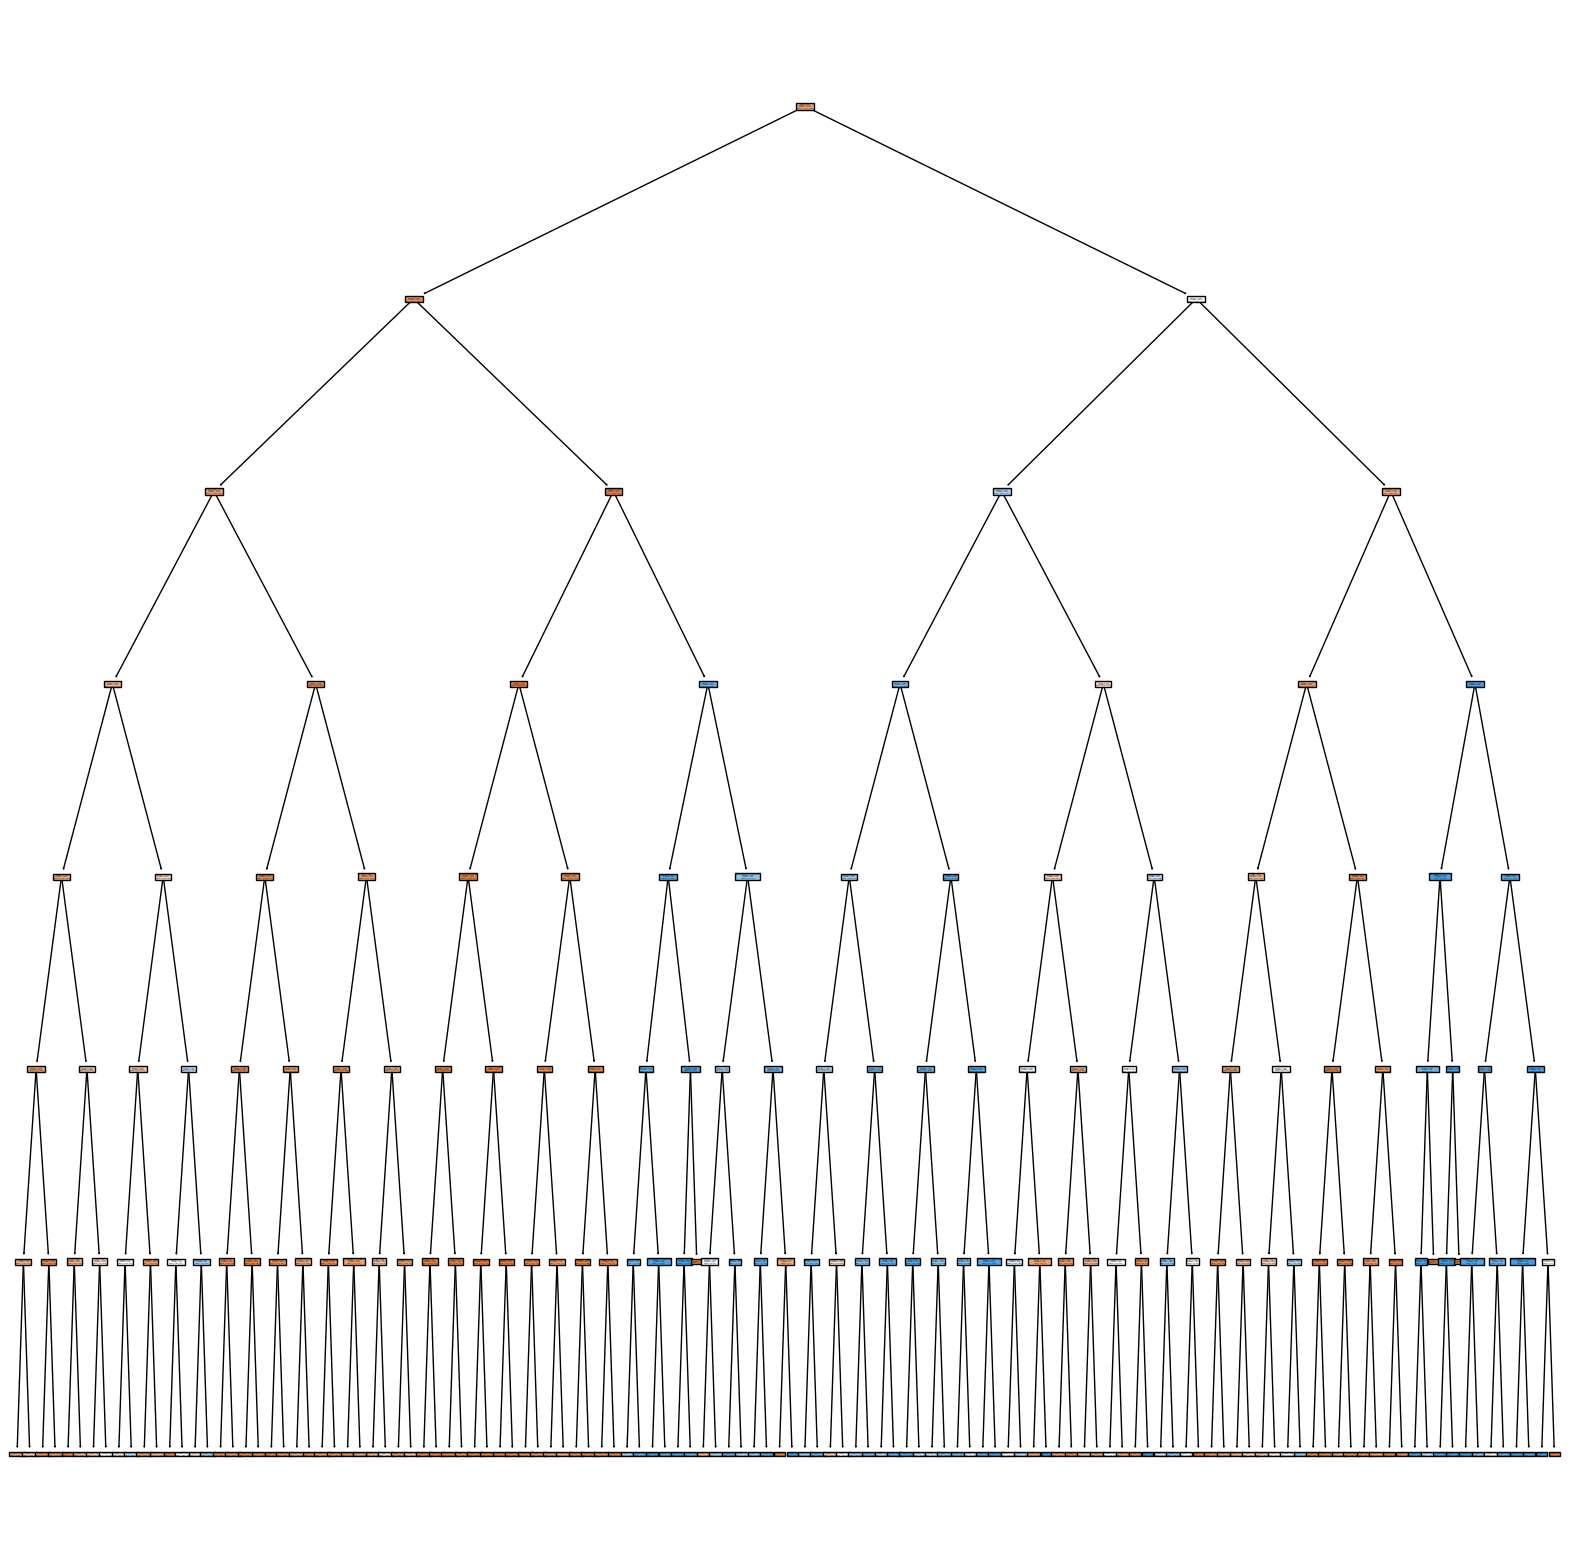

In [5]:
# visualize pruned tree
plt.figure(figsize=(20,20))
features = list(X_train.columns)
plot_tree(tree_pruned,feature_names=features,filled=True)
plt.show()

In [6]:
# refit model on training set with optimal criterion and depth
tree_pruned.fit(X = X_train, y = y_train)

# predict on the training set
y_pred_pruned = tree_pruned.predict(X_train)
accuracy_pruned = accuracy_score(y_train, y_pred_pruned)
print(f"Accuracy on training set: {accuracy_pruned:.4f}")

# AUC on training set
y_probs_train = tree_pruned.predict_proba(X_train)[:, 1] # compute probabilities

# ROC curve
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC on training set is {}'.format(roc_auc_train))


# predict on the test set
y_pred_pruned_test = tree_pruned.predict(X_test)
accuracy_pruned_test = accuracy_score(y_test, y_pred_pruned_test)
print(f"Accuracy on test set: {accuracy_pruned_test:.4f}")

# AUC on test set
y_probs_test = tree_pruned.predict_proba(X_test)[:, 1] # compute probabilities

# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC on test set is {}'.format(roc_auc_test))

Accuracy on training set: 0.8641
AUC on training set is 0.8862223330825877
Accuracy on test set: 0.8631
AUC on test set is 0.8827274323361824


In [10]:
# confusion matrix
import seaborn as sns

classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Greens', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

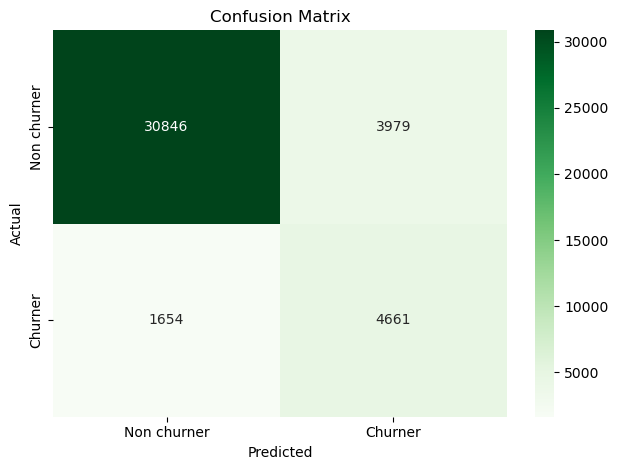

In [11]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_pred_pruned_test,y_test)

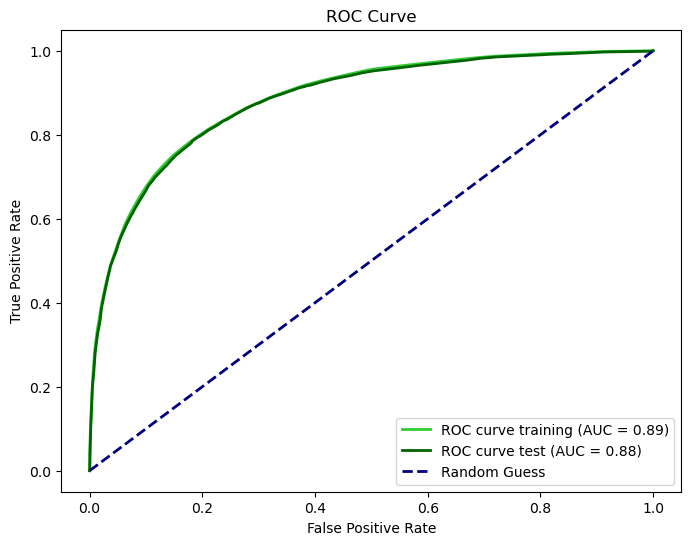

In [12]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='limegreen', lw=2, label=f'ROC curve training (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color = 'darkgreen', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Decision tree performs as well as k-NN. We prefer the decision tree to k-NN, though, because k-NN is a lazy learner, and would take require quite some time for new predictions.

In [13]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test_lr = precision_score(y_test, y_pred_pruned_test)
# recall
recall_test_lr = recall_score(y_test, y_pred_pruned_test)
# f1-measure
f1_test_lr = f1_score(y_test, y_pred_pruned_test)

print('Precision on the test set is {}'.format(precision_test_lr))
print('Recall on the test set is {}'.format(recall_test_lr))
print('f1-measure on the test set is {}'.format(f1_test_lr))

Precision on the test set is 0.7380839271575613
Recall on the test set is 0.5394675925925926
f1-measure on the test set is 0.623336676696757


In [14]:
import pickle

# save model
model_name='decision_tree.pkl'
model_file=open(model_name,'wb')
pickle.dump(tree_pruned, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)